In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import sqlite3
import re

def html_tags_to_unicode(text):
    # Convert <sup>...</sup> content to Unicode superscript
    text = re.sub(r'<sup>(.*?)</sup>', lambda m: m.group(1).translate(SUPERSCRIPTS), text)
    # Convert <sub>...</sub> content to Unicode subscript
    text = re.sub(r'<sub>(.*?)</sub>', lambda m: m.group(1).translate(SUBSCRIPTS), text)
    return text

SUPERSCRIPTS = str.maketrans('0123456789+-=()n i', '⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ ⁱ')
SUBSCRIPTS   = str.maketrans('0123456789+-=()',   '₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎')

# Connect to the .db file
conn = sqlite3.connect('../data/NIST_SRD_46_ported.db')
cursor = conn.cursor()

# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# # Read a specific table into pandas
import pandas as pd
df_verkn_ligand_metal = pd.read_sql_query("SELECT * FROM verkn_ligand_metal", conn)
df_liganden = pd.read_sql_query("SELECT * FROM liganden", conn)
df_metal = pd.read_sql_query("SELECT * FROM metal", conn)
df_mol_data = pd.read_sql_query("SELECT * FROM mol_data", conn)
df_beta_definition = pd.read_sql_query("SELECT * FROM beta_definition", conn)
df_constanttyp = pd.read_sql_query("SELECT * FROM constanttyp", conn)
df_ligand_class = pd.read_sql_query("SELECT * FROM ligand_class", conn)
df_footnote = pd.read_sql_query("SELECT * FROM footnote", conn)

# # Don't forget to close the connection
conn.close()
tables

[('beta_definition',),
 ('sqlite_sequence',),
 ('beta_definition_sic',),
 ('constanttyp',),
 ('footnote',),
 ('ligand_class',),
 ('liganden',),
 ('literature',),
 ('literature_alt',),
 ('metal',),
 ('mol_data',),
 ('paper',),
 ('solvent',),
 ('verk_literature_author',),
 ('verkn_ligand_metal',),
 ('verkn_ligand_metal_literature',),
 ('verkn_ligand_metal_literature_sic',),
 ('verkn_ligand_metal_sic',),
 ('author',)]

In [33]:

df_liganden['ligandenNr'] = df_liganden['ligandenID']
df_liganden['Ligand'] = df_liganden['name_ligand']
df_liganden['Formula'] = df_liganden['formula']
df_liganden['Figure definition'] = df_liganden['figure_definition']

# df_liganden['ligand_classID'] = df_liganden['ligand_classNr']
df_ligand_class['ligand_classNr'] = df_ligand_class['ligand_classID']
df_ligand_class['Ligand class'] = df_ligand_class['name_ligandclass']
df_ligand_class.head()


,ligand_classID,name_ligandclass,comment,Field4,ligand_classNr,Ligand class
0,1,Amino Acids,\N,2008-01-06 18:19:03,1,Amino Acids
1,2,Aza macrocycles with carboxylic acids,\N,2008-01-06 18:19:03,2,Aza macrocycles with carboxylic acids
2,3,Iminodiacetic acid and derivatives,\N,2008-01-06 18:19:03,3,Iminodiacetic acid and derivatives
3,4,NTA and derivatives,\N,2008-01-06 18:19:03,4,NTA and derivatives
4,5,EDTA and derivatives,\N,2008-01-06 18:19:03,5,EDTA and derivatives


In [34]:

df_metal['Metal ion'] = df_metal['name_metal']
df_metal['metalNr'] = df_metal['metalID']

df_beta_definition['Equilibrium'] = df_beta_definition['name_beta_definition']
df_beta_definition['beta_definitionNr'] = df_beta_definition['beta_definitionID']

df_constanttyp['constanttypNr'] = df_constanttyp['constanttypID']
df_constanttyp['name_constanttyp'] = ['', 'DH (kJ/mol)', 'Log K', 'DS (J/mol.K)']
df_constanttyp['Value type'] = df_constanttyp['name_constanttyp']

df_verkn_ligand_metal['Value'] = df_verkn_ligand_metal['constant']
df_verkn_ligand_metal['Temperature (C)'] = df_verkn_ligand_metal['temperature'].apply(lambda x: re.sub('tv','', x))
df_verkn_ligand_metal['Ionic strength'] = df_verkn_ligand_metal['ionicstrength']

df_liganden = df_liganden.merge(df_ligand_class[['ligand_classNr','Ligand class']], on='ligand_classNr', how='left')

df_all = df_verkn_ligand_metal.merge(df_liganden[['ligandenNr', 'Ligand', 'Ligand class', 'Formula', 'Figure definition']], on='ligandenNr', how='left')
df_all = df_all.merge(df_metal[['metalNr', 'Metal ion']], on='metalNr', how='left')
df_all = df_all.merge(df_beta_definition[['beta_definitionNr', 'Equilibrium']], on='beta_definitionNr', how='left')
df_all = df_all.merge(df_constanttyp[['constanttypNr', 'Value type']], on='constanttypNr', how='left')
df_all = df_all[~df_all.astype(str).apply(lambda x: x.str.contains(r'\*')).any(axis=1)]
# clean up
df_all.dropna(inplace=True)
df_all.reset_index(drop=True, inplace=True)
df_all['Value'] = df_all['Value'].apply(lambda x: x.strip('()'))
df_all['Metal ion'] = df_all['Metal ion'].apply(html_tags_to_unicode)
df_all['Equilibrium'] = df_all['Equilibrium'].apply(html_tags_to_unicode)
df = df_all[['Metal ion', 'Ligand', 'Formula', 'Figure definition', 'Ligand class', 'Equilibrium', 'Temperature (C)', 'Ionic strength', 'Value type', 'Value']]

In [65]:
df = df[df['Value type'] == 'Log K']

In [66]:
df.to_csv('../data/stability_constant_unique.csv', index=False, encoding='utf-8-sig')

---

# Analysis

In [92]:
df_raw = pd.read_csv('../data/stability_constant_unique.csv')
df_new = pd.read_csv('../data/NIST_database_onlyH_6TypeEq_pos_match_max_fg_other.csv')

In [93]:
df_raw_H = df_raw[df_raw['Metal ion'] == 'H⁺']

In [94]:
# 需要用來唯一識別一組記錄的欄位
index_cols = [
    'Metal ion', 'Ligand', 'Ligand class',
    'Temperature (C)', 'Ionic strength', 'Equilibrium'
]

# 2. 先複製，避免動到原 DataFrame
df1 = df_raw_H.copy()
df2 = df_new.copy()

# 3. 在每一個重複組內加流水號，確保索引唯一 ---------------------
df1['dup_id'] = df1.groupby(index_cols).cumcount()
df2['dup_id'] = df2.groupby(index_cols).cumcount()

full_index = index_cols + ['dup_id']

s1 = df1.set_index(full_index)['Value']
s2 = df2.set_index(full_index)['Value']

# 4. 只比對交集，確保一一對齊
s1_aligned, s2_aligned = s1.align(s2, join='inner')

cmp = pd.concat(
    [s1_aligned.rename('Value_raw'),
     s2_aligned.rename('Value_new')],
    axis=1
)

# 5. 找真正不相等的列（浮點可加誤差容忍）
mismatch = cmp[~cmp['Value_raw'].eq(cmp['Value_new'])]      # 嚴格相等
# mismatch = cmp[~np.isclose(cmp['Value_raw'], cmp['Value_new'], atol=1e-3)]  # 可容忍誤差

# 6. 如果要看結果或輸出
mismatch = mismatch.reset_index()         # 讓索引欄位回到表中
mismatch.to_csv('value_mismatch.csv', index=False)


數值都是正確的

---

In [109]:
f = 'stability_constant_unique.csv'
df = pd.read_csv(f)
# df.drop_duplicates(inplace=True)
# df = df[(df['Equilibrium'] != '*')]
# df.sort_values(by='Metal ion', inplace=True)

In [247]:
df = df[(df['Ionic strength'].astype(float) == 0.1) & (df['Temperature (C)'].astype(float) == 25) & (df['Value type'] == 'Log K')].sort_values(by='Metal ion', ascending=True).reset_index(drop=True)
df

,Metal ion,Ligand,Formula,Figure definition,Ligand class,Equilibrium,Temperature (C),Ionic strength,Value type,Value
0,Ac³⁺,Ethanedioic acid,C2H2O4,H2L,Carboxylic acids diacids hydroxy,[ML]/[M][L],25,0.1,Log K,4.36
1,Ac³⁺,Ethanedioic acid,C2H2O4,H2L,Carboxylic acids diacids hydroxy,[ML₂]/[M][L]²,25,0.1,Log K,7.08
2,Ag²⁺,"1,4,8,11-Tetraazacyclotetradecane-N,N',N'',N''...",C18H32N4O8,H4L,Iminodiacetic acid and derivatives,[ML]/[M][L],25,0.1,Log K,39.3
3,Ag²⁺,"1,4,8,11-Tetraazacyclotetradecane(Cyclam)",C10H24N4,L,Aza-oxa-macrocycles,[ML]/[M][L],25,0.1,Log K,43.4
4,Ag²⁺,"1,4,7,10,13-Pentaazacyclopentadecane",C10H25N5,L,Aza-oxa-macrocycles,[ML]/[M][L],25,0.1,Log K,43.6
...,...,...,...,...,...,...,...,...,...,...
29112,Zr⁴⁺,Ethylenedinitrilotetraacetic acid,C10H16N2O8,H4L,Peptides,[ML]/[M][L],25,0.1,Log K,29.3
29113,m-NO₂PhB(OH)₂,"1,2-Dihydroxy-4-methylbenzene",C7H8O2,H2L,Catechols fuchsons,[M(OH)L][H]/[M(OH)₂][H₂L],25,0.1,Log K,-3.3
29114,m-NO₂PhB(OH)₂,2-Hydroxybenzoic acid,C7H6O3,H2L,Catechols,[M(OH)L][H]/[M(OH)₂][H₂L],25,0.1,Log K,0.04
29115,m-NO₂PhB(OH)₂,"1,2-Dihydroxy-4-nitrobenzene",C6H5N1O4,H2L,Catechols fuchsons,[M(OH)L][H]/[M(OH)₂][H₂L],25,0.1,Log K,-1.8


In [248]:
eqs_metal = df[df['Metal ion'] != 'H⁺'].groupby(['Metal ion', 'Ligand']).apply(
    lambda g: dict(zip(g['Equilibrium'], g['Value']))
).reset_index(name='Equilibrium-Value')
eqs_H = df[df['Metal ion'] == 'H⁺'].groupby(['Metal ion', 'Ligand']).apply(
    lambda g: dict(zip(g['Equilibrium'], g['Value']))
).reset_index(name='Equilibrium-Value')


In [249]:
eqs = eqs_metal.merge(eqs_H, on=['Ligand'], how='inner').sort_values(by=['Metal ion_x', 'Ligand'], ascending=True)

In [278]:
eqs_filtered = []
ion_effect = defaultdict(dict)
for i in eqs.values:
    eq_labels = list(i[2].keys())
    if '[MHL]/[ML][H]' in eq_labels:
        print(i)
        kas = np.array(list(i[4].values())).astype(float)
        kas_diff = np.array(list(i[4].values())).astype(float) - float(i[2]['[MHL]/[ML][H]'])
        if kas_diff.any() < 0:
            ka = kas[kas_diff < 0][kas_diff[kas_diff < 0].argsort()[-1]]
            ka_p = float(i[2]['[MHL]/[ML][H]']) / ka
            ion_effect[i[0]][i[1]] = Ka_p
            eqs_filtered.append(i)
    elif '[MHL]/[M][HL]' in eq_labels and '[ML]/[M][L]' in eq_labels:
        print(i)
        if float(i[2]['[MHL]/[M][HL]']) != 0:
            Ka_p = float(i[2]['[ML]/[M][L]']) / float(i[2]['[MHL]/[M][HL]'])
            ion_effect[i[0]][i[1]] = Ka_p
            eqs_filtered.append(i)


['Ag⁺' '(2-Carboxyethylthio)acetic acid'
 {'[MH₂L]/[M][H₂L]': '3.45', '[M(H₂L)₂]/[M][H₂L]²': '6.01', '[ML₂]/[M][L]²': '7.46', '[MHL]/[M][HL]': '3.63', '[ML]/[M][L]': '4.40'}
 'H⁺' {'[H₂L]/[HL][H]': '3.27', '[HL]/[L][H]': '4.34'}]
['Ag⁺' '(2-Hydroxytrimethylene)dinitrilotetraacetic acid'
 {'[ML]/[M][L]': '5.28', '[MHL]/[ML][H]': '7.60', '[M₂L]/[M]²[L]': '8.3'}
 'H⁺'
 {'[H₄L]/[H₃L][H]': '1.7', '[H₃L]/[H₂L][H]': '2.57', '[H₂L]/[HL][H]': '6.95', '[HL]/[L][H]': '9.49'}]
['Ag⁺' '(Benzylthio)acetic acid'
 {'[ML]/[M][L]': '3.69', '[ML₂]/[M][L]²': '6.8', '[MHL]/[M][HL]': '2.92'}
 'H⁺' {'[HL]/[L][H]': '3.60'}]
['Ag⁺' '(But-3-enylseleno)acetic acid'
 {'[ML]/[M][L]': '5.0', '[MHL]/[M][HL]': '4.75', '[M₂HL]/[MHL][M]': '2.79', '[M₂L]/[M]²[L]': '1.97', '[ML₂]/[M][L]²': '8.0'}
 'H⁺' {'[HL]/[L][H]': '3.77'}]
['Ag⁺' '(But-3-enylthio)acetic acid'
 {'[ML]/[M][L]': '4.74', '[ML₂]/[M][L]²': '7.0', '[MHL]/[M][HL]': '4.16', '[M(HL)₂]/[M][HL]²': '6.37', '[M₂L]/[M]²[L]': '6.83'}
 'H⁺' {'[HL]/[L][H]': '3.61'}]
[

In [271]:
dict(sorted(ion_effect['Fe³⁺'].items(), key=lambda item: item[1]))

{'L-2-Amino-3-(4-imidazolyl)propanohydroxamic acid': 26915.348039269138,
 'Aminoacetohydroxamic acid': 28840.315031266116,
 '2-Hydroxypropane-1,2,3-tricarboxylic acid': 30902.954325135855,
 'Amino(phenyl)methylenediphosphonic acid': 117489.75549395254,
 '1,3-Dihydroxy-4-(2-pyridylazo)benzene': 40738027.7804113,
 '7,19-Bis(carboxymethyl)-1,13(2,3)-tetrahydroxy-2,12,14,24-tetraoxo-3,7,11,15,19,23-hexaaza-1,13(1,4)-dibenzenacyclotetracosanophane': 2.04173794466954e+26,
 '6,16-Bis(carboxymethyl)-1,11(2,3)-tetrahydroxy-2,10,12,20-tetraoxo-3,6,9,13,16,19-hexaaza-1,11(1,4)-dibenzenacycloeicosanophane': 2.511886431509592e+27,
 '1,4,7-Tris(3-hydroxy-6-methyl-2-pyridylmethyl)-1,4,7-triazacyclononane': 7.244359600749891e+43}

In [266]:
eqs[(eqs['Ligand'] == 'Oxydiacetic acid') & (eqs['Metal ion_x'] == 'Mg²⁺')].values

array([['Mg²⁺', 'Oxydiacetic acid',
        {'[MHL]/[M][HL]': '-0.3', '[ML]/[M][L]': '1.7'}, 'H⁺',
        {'[HL]/[L][H]': '4.00', '[H₂L]/[HL][H]': '2.82'}]], dtype=object)

In [240]:
df_all[(df_all['Metal ion'] == 'Cu²⁺') & (df_all['Ligand'] == '1,4,7,10,13-Pentaazacyclopentadecane')]

,verkn_ligand_metalID,ligandenNr,metalNr,beta_definitionNr,constanttypNr,temperature,ionicstrength,constant,constant_sic,error,...,Value,Temperature (C),Ionic strength,Ligand,Ligand class,Formula,Figure definition,Metal ion,Equilibrium,Value type
33922,129963,7499,41,812,3,25,0.1,27.0,27.0,+/-1,...,27.0,25,0.1,"1,4,7,10,13-Pentaazacyclopentadecane",Aza-oxa-macrocycles,C10H25N5,L,Cu²⁺,[ML]/[M][L],Log K
33923,129964,7499,41,812,2,25,0.1,(-138.1),(-33),0,...,-138.1,25,0.1,"1,4,7,10,13-Pentaazacyclopentadecane",Aza-oxa-macrocycles,C10H25N5,L,Cu²⁺,[ML]/[M][L],DH (kJ/mol)
33924,129965,7499,41,812,4,25,0.1,(54.4),(13),0,...,54.4,25,0.1,"1,4,7,10,13-Pentaazacyclopentadecane",Aza-oxa-macrocycles,C10H25N5,L,Cu²⁺,[ML]/[M][L],DS (J/mol.K)
33925,129966,7499,41,779,3,25,0.1,(1.0),(1.0),0,...,1.0,25,0.1,"1,4,7,10,13-Pentaazacyclopentadecane",Aza-oxa-macrocycles,C10H25N5,L,Cu²⁺,[MHL]/[M][HL],Log K


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


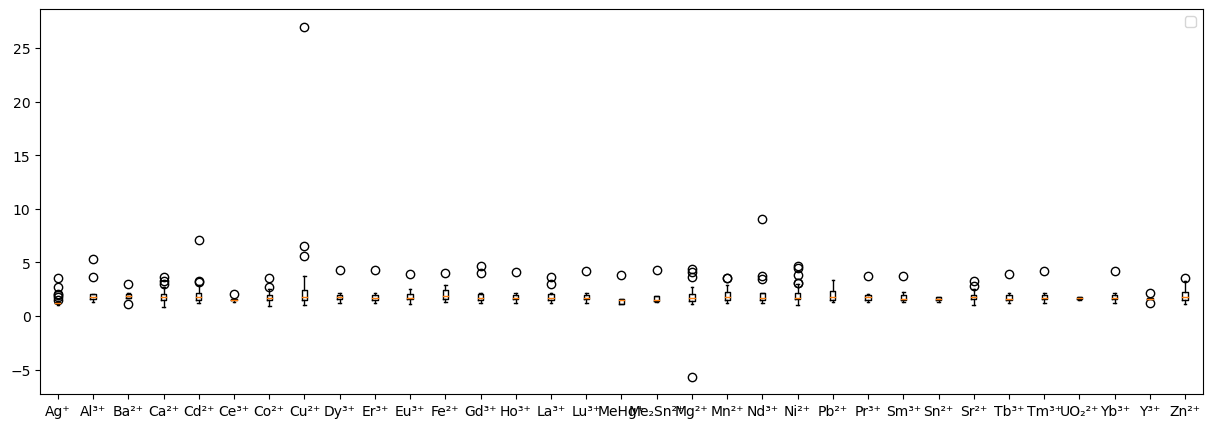

In [279]:
fig, ax = plt.subplots(figsize=(15, 5))
counter = 0
for i, (key, value) in enumerate(ion_effect.items()):
    if len(value) > 4 and not key == 'Fe³⁺' and not key == 'Ga³⁺':
        ax.boxplot(value.values(), positions=[counter], labels=[key])
        counter += 1
    # elif len(value) > 4 and key == 'Fe³⁺':
    #     ax.boxplot(sorted(value.values())[:-4], positions=[counter], labels=[key])
    #     counter += 1
ax.legend(ncol=4)
plt.show()

In [252]:
{key: len(value) for key, value in ion_effect.items() if len(value) > 4}

{'Ag⁺': 32,
 'Al³⁺': 14,
 'Ba²⁺': 10,
 'Ca²⁺': 44,
 'Cd²⁺': 34,
 'Ce³⁺': 5,
 'Co²⁺': 41,
 'Cu²⁺': 93,
 'Dy³⁺': 12,
 'Er³⁺': 11,
 'Eu³⁺': 13,
 'Fe²⁺': 12,
 'Fe³⁺': 8,
 'Ga³⁺': 5,
 'Gd³⁺': 12,
 'Ho³⁺': 9,
 'La³⁺': 16,
 'Lu³⁺': 10,
 'MeHg⁺': 5,
 'Me₂Sn²⁺': 5,
 'Mg²⁺': 40,
 'Mn²⁺': 30,
 'Nd³⁺': 13,
 'Ni²⁺': 54,
 'Pb²⁺': 20,
 'Pr³⁺': 10,
 'Sm³⁺': 11,
 'Sn²⁺': 6,
 'Sr²⁺': 17,
 'Tb³⁺': 9,
 'Tm³⁺': 11,
 'UO₂²⁺': 8,
 'Yb³⁺': 9,
 'Y³⁺': 7,
 'Zn²⁺': 50}